In [1]:
%load_ext autoreload
%autoreload 2

from neural_circuits.LRRNN import get_W_eigs_np
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt

import torch
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
torch.manual_seed(0)

"""SNPE: RNN stable amplification."""

'SNPE: RNN stable amplification.'

In [2]:
g = 0.0001
K = 1
_W_eigs = get_W_eigs_np(g, K)

N = 2
RANK = 2
num_dim = 2*N*RANK
prior = utils.BoxUniform(low=-1.*torch.ones(num_dim), high=1.*torch.ones(num_dim))

def simulator(params):
    params = params.numpy()
    U = np.reshape(params[:(RANK*N)], (N,RANK))
    V = np.reshape(params[(RANK*N):], (N,RANK))
    x = _W_eigs(U, V)
    return x

In [3]:
simulator, prior = prepare_for_sbi(simulator, prior)
density_estimator_build_fun = posterior_nn(model='maf', hidden_features=50, num_transforms=2,
                                           z_score_x=False, z_score_theta=False,
                                           support_map=True)
x_0 = torch.tensor([0.5, 1.5])

inference = SNPE(prior, density_estimator=density_estimator_build_fun)

In [12]:
theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=100)
maf = density_estimator_build_fun(theta, x)
for param in maf.parameters():
    print(param.name, param.shape)

Running 100 simulations.:   0%|          | 0/100 [00:00<?, ?it/s]

None torch.Size([50, 8])
None torch.Size([50])
None torch.Size([50, 2])
None torch.Size([50])
None torch.Size([50])
None torch.Size([50])
None torch.Size([50, 50])
None torch.Size([50])
None torch.Size([50])
None torch.Size([50])
None torch.Size([50, 50])
None torch.Size([50])
None torch.Size([16, 50])
None torch.Size([16])
None torch.Size([50, 8])
None torch.Size([50])
None torch.Size([50, 2])
None torch.Size([50])
None torch.Size([50])
None torch.Size([50])
None torch.Size([50, 50])
None torch.Size([50])
None torch.Size([50])
None torch.Size([50])
None torch.Size([50, 50])
None torch.Size([50])
None torch.Size([16, 50])
None torch.Size([16])


In [14]:
num_rounds = 2
persist_rounds = 5
best_round = 0

posteriors = []
proposal = prior
for r in range(num_rounds):
    if r == 0:
        print('Round %d:' % (r+1))
    else:
        print('Round %d, Best (%d):' % (r+1, best_round+1))
    theta, x = simulate_for_sbi(simulator, proposal=proposal, num_simulations=100)
    inference = inference.append_simulations(theta, x)
    density_estimator = inference.train(training_batch_size=25)
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    best_round = np.argmax(inference.summary['best_validation_log_probs'])
    if best_round + persist_rounds == r:
        break
    proposal = posterior.set_default_x(x_0)

Round 1:


Running 100 simulations.:   0%|          | 0/100 [00:00<?, ?it/s]

Neural network successfully converged after 25 epochs.
Round 2, Best (1):


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations.:   0%|          | 0/100 [00:00<?, ?it/s]

Neural network successfully converged after 24 epochs.


In [15]:
for i, param in enumerate(density_estimator.parameters()):
    print(i, param.name, param.shape)


0 None torch.Size([50, 8])
1 None torch.Size([50])
2 None torch.Size([50, 2])
3 None torch.Size([50])
4 None torch.Size([50])
5 None torch.Size([50])
6 None torch.Size([50, 50])
7 None torch.Size([50])
8 None torch.Size([50])
9 None torch.Size([50])
10 None torch.Size([50, 50])
11 None torch.Size([50])
12 None torch.Size([16, 50])
13 None torch.Size([16])
14 None torch.Size([50, 8])
15 None torch.Size([50])
16 None torch.Size([50, 2])
17 None torch.Size([50])
18 None torch.Size([50])
19 None torch.Size([50])
20 None torch.Size([50, 50])
21 None torch.Size([50])
22 None torch.Size([50])
23 None torch.Size([50])
24 None torch.Size([50, 50])
25 None torch.Size([50])
26 None torch.Size([16, 50])
27 None torch.Size([16])


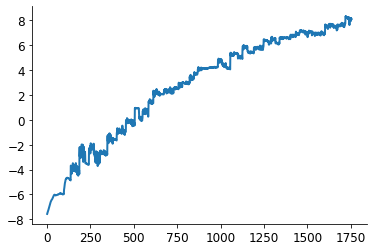

In [5]:
epochs = len(inference._summary['validation_log_probs'])
plt.plot(range(1, epochs+1), inference._summary['validation_log_probs'])

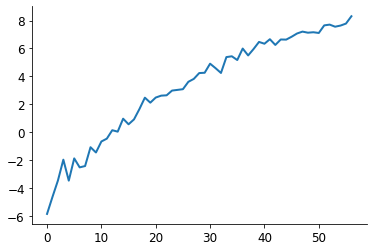

In [6]:
plt.plot(inference.summary['best_validation_log_probs'])

In [7]:
zs = []
for posterior in posteriors:
    zs.append(posterior.sample((1000,), x=x_0).numpy())
print(zs)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

[array([[ 0.01500356,  0.96565366,  0.07740045, ...,  0.96760094,
         0.9564146 , -0.831045  ],
       [-0.15810871,  0.9791548 ,  0.9917021 , ...,  0.9460956 ,
         0.8917315 , -0.2403841 ],
       [ 0.2570052 ,  0.9989039 ,  0.9272219 , ...,  0.02694488,
        -0.9983494 ,  0.10712314],
       ...,
       [ 0.9664165 , -0.833975  ,  0.42950308, ..., -0.20274997,
         0.75395644,  0.9746871 ],
       [ 0.8928093 ,  0.273412  , -0.88922745, ...,  0.777712  ,
         0.96881735, -0.35210007],
       [ 0.6670191 , -0.26224297, -0.98882866, ..., -0.51632535,
        -0.7700566 , -0.7894536 ]], dtype=float32), array([[ 0.04501259,  0.43316245,  0.99497485, ...,  0.99666774,
        -0.99456793, -0.9474864 ],
       [ 0.8969239 , -0.926737  ,  0.9144107 , ...,  0.3151797 ,
         0.99902344,  0.9703615 ],
       [-0.2314812 , -0.09501493,  0.670601  , ...,  0.19535053,
         0.20631409, -0.17420238],
       ...,
       [-0.4707852 , -0.42419064,  0.8659774 , ..., -0.354

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

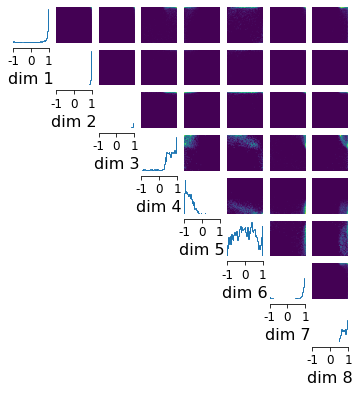

In [9]:
samples = posterior.sample((1000,), x=x_0)
log_probability = posterior.log_prob(samples, x=x_0)
limits = num_dim*[[-1, 1]]
_ = analysis.pairplot(samples, limits=limits, figsize=(6,6))

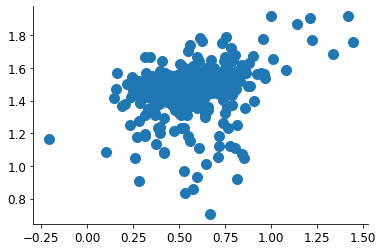

In [10]:
import matplotlib.pyplot as plt
predictions = simulator(samples).numpy()
plt.scatter(predictions[:,0], predictions[:,1])


In [7]:
"""density_estimator = density_estimator_build_fun(theta, x)

observation = torch.zeros(3)
posterior = inference.build_posterior(density_estimator)

samples = posterior.sample((1000,), x=observation)
print('max', torch.max(samples))
print('min', torch.min(samples))
print('less 0', torch.sum(samples < 0))
print('more 1', torch.sum(samples > 1))
print(samples)"""

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]